In [1]:
#scan.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 2 August 2020.
#this...

In [2]:
#get path to all simulations
import os
parent_path = 'permutations/'
paths = os.listdir(parent_path)
paths.remove('.gitignore')
paths = [parent_path + path for path in paths]
print 'number of paths = ', len(paths)
paths[0:5]

number of paths =  27


['permutations/total_ring_mass=2e-10_radial_width=0.0007_shear_viscosity=1e-12_timesteps_per_output=8232_',
 'permutations/total_ring_mass=2e-08_radial_width=0.0005_shear_viscosity=1e-12_timesteps_per_output=4200_',
 'permutations/total_ring_mass=2e-09_radial_width=0.0005_shear_viscosity=1e-11_timesteps_per_output=420_',
 'permutations/total_ring_mass=2e-10_radial_width=0.0007_shear_viscosity=1e-11_timesteps_per_output=823_',
 'permutations/total_ring_mass=2e-10_radial_width=0.0003_shear_viscosity=1e-10_timesteps_per_output=15_']

In [3]:
#prep plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd

permutations/total_ring_mass=2e-10_radial_width=0.0007_shear_viscosity=1e-12_timesteps_per_output=8232_ 5
permutations/total_ring_mass=2e-08_radial_width=0.0005_shear_viscosity=1e-12_timesteps_per_output=4200_ 5
permutations/total_ring_mass=2e-09_radial_width=0.0005_shear_viscosity=1e-11_timesteps_per_output=420_ 100
path =  permutations/total_ring_mass=2e-09_radial_width=0.0005_shear_viscosity=1e-11_timesteps_per_output=420_
total_ring_mass =  2e-09
radial_width =  0.0005
shear_viscosity =  1e-11
viscous_timescale =  2083.333333333333
current_timestep =  420000 420000
execution time (minutes) =  21.9833333333
permutations/total_ring_mass=2e-10_radial_width=0.0007_shear_viscosity=1e-11_timesteps_per_output=823_ 5
permutations/total_ring_mass=2e-10_radial_width=0.0003_shear_viscosity=1e-10_timesteps_per_output=15_ 100
path =  permutations/total_ring_mass=2e-10_radial_width=0.0003_shear_viscosity=1e-10_timesteps_per_output=15_
total_ring_mass =  2e-10
radial_width =  0.0003
shear_viscosi

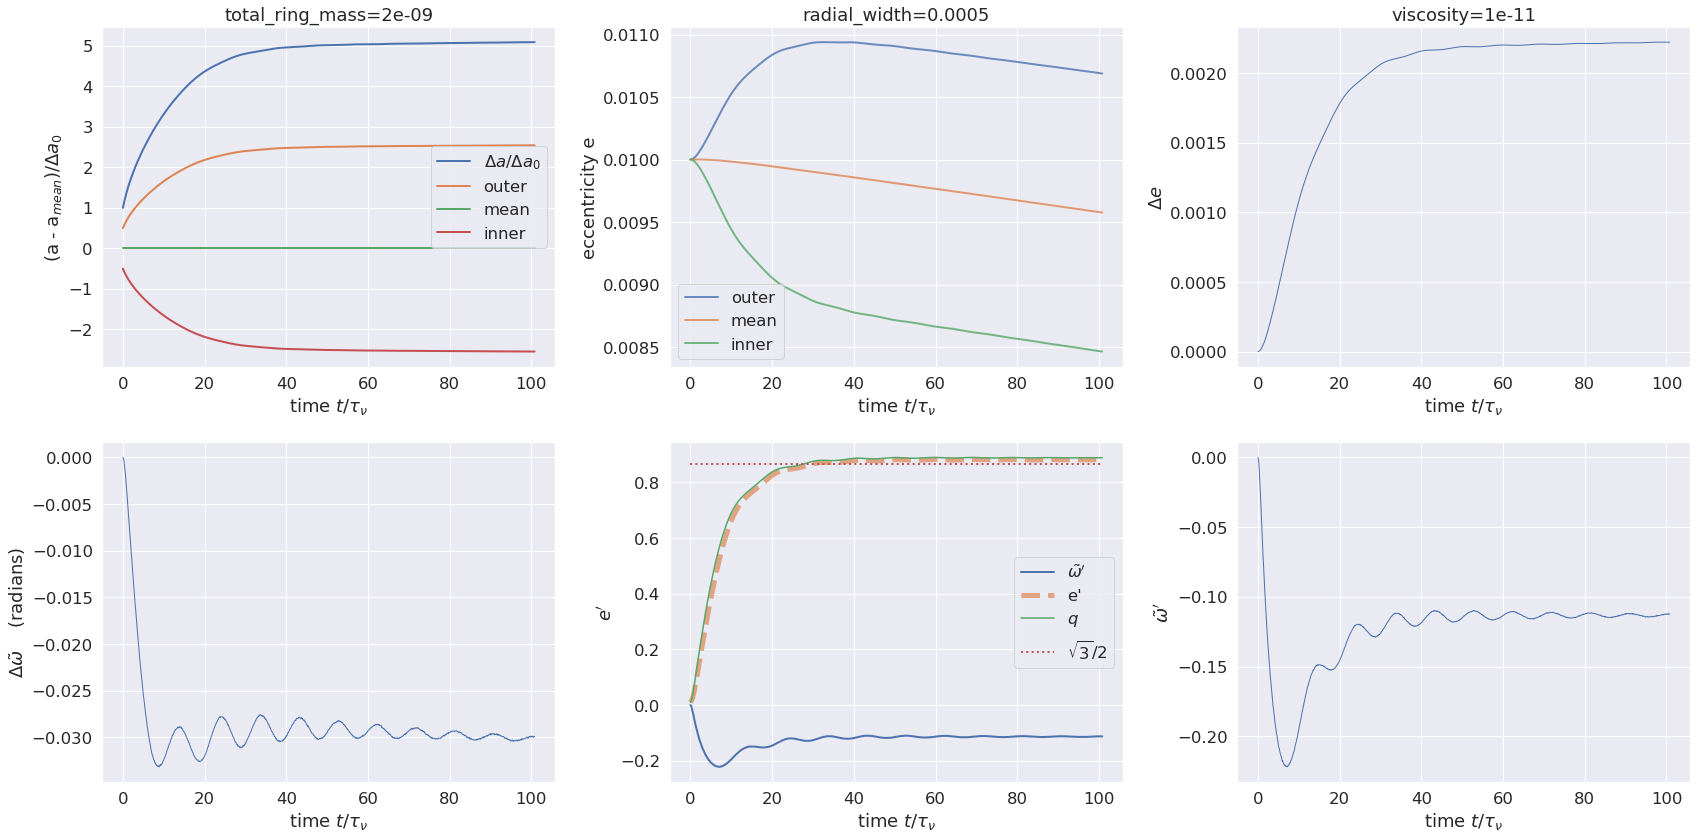

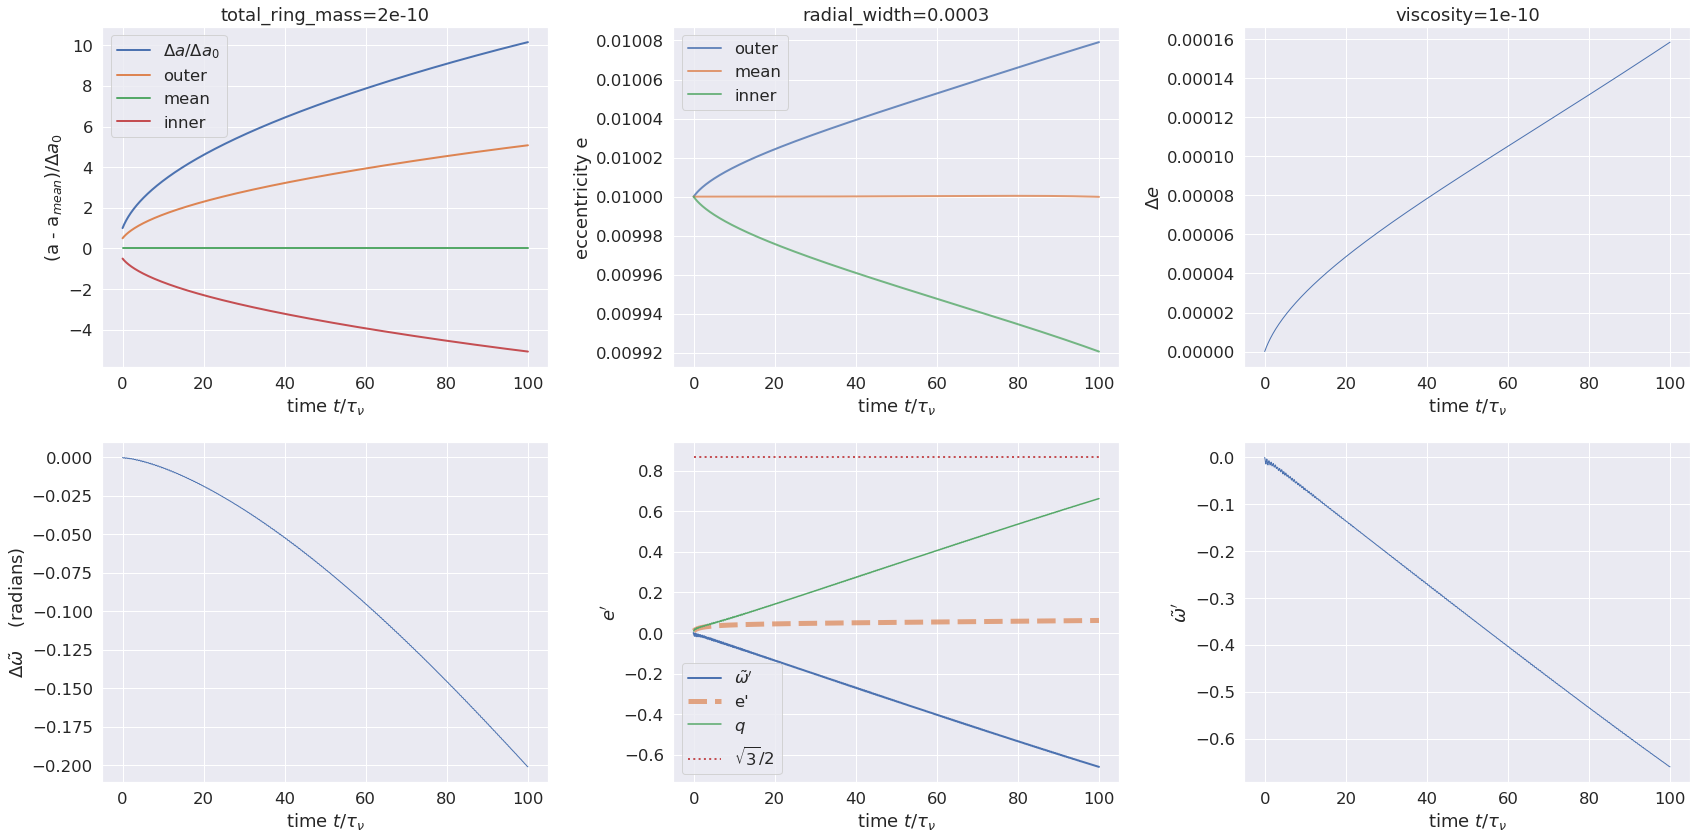

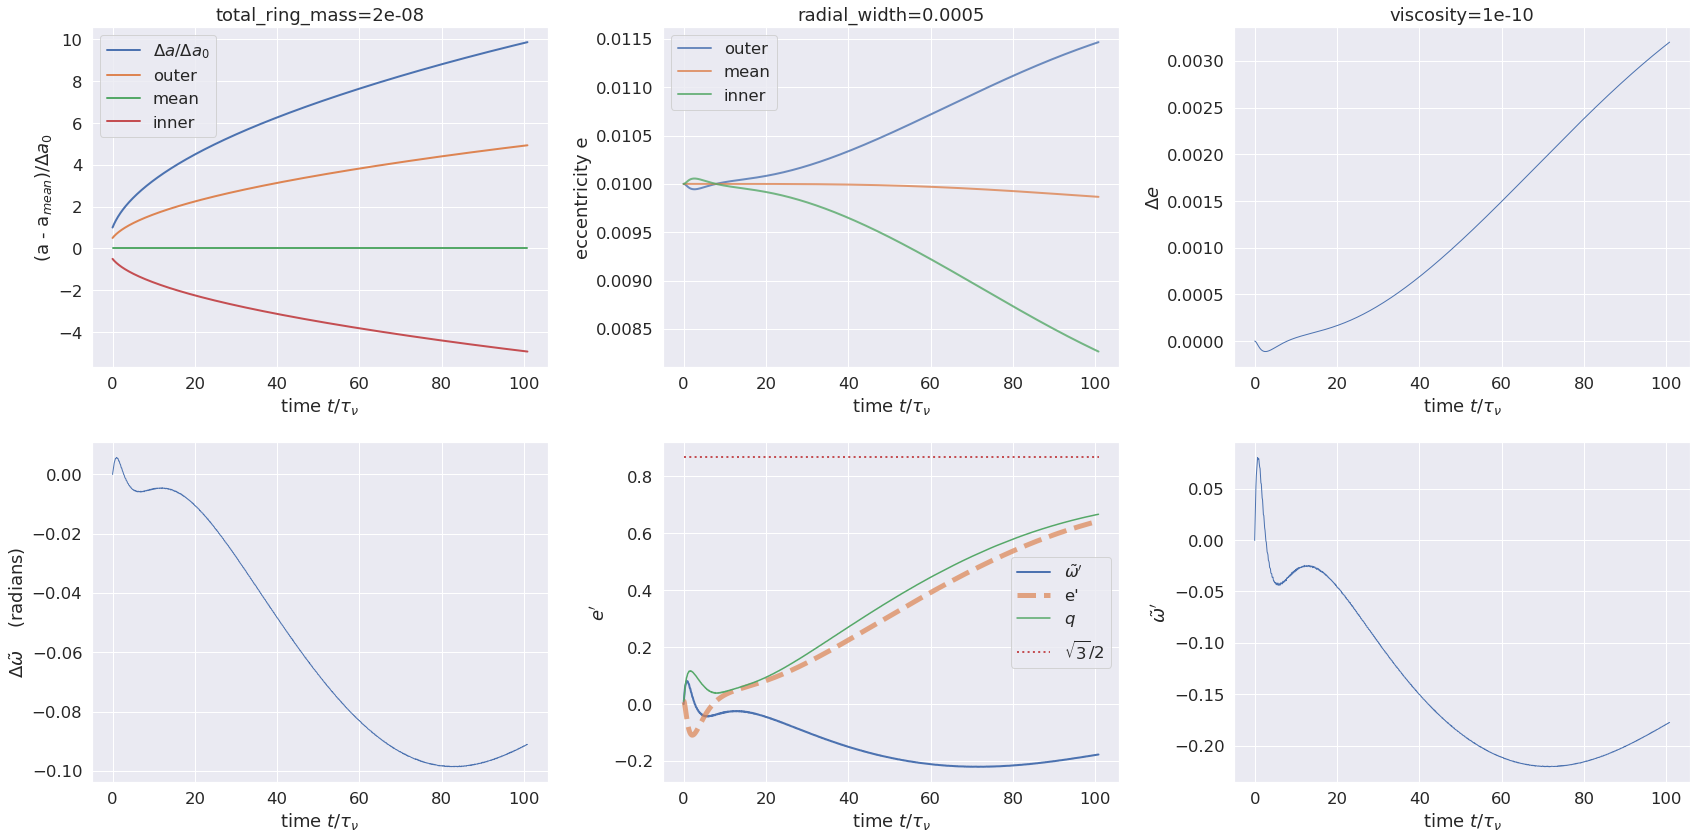

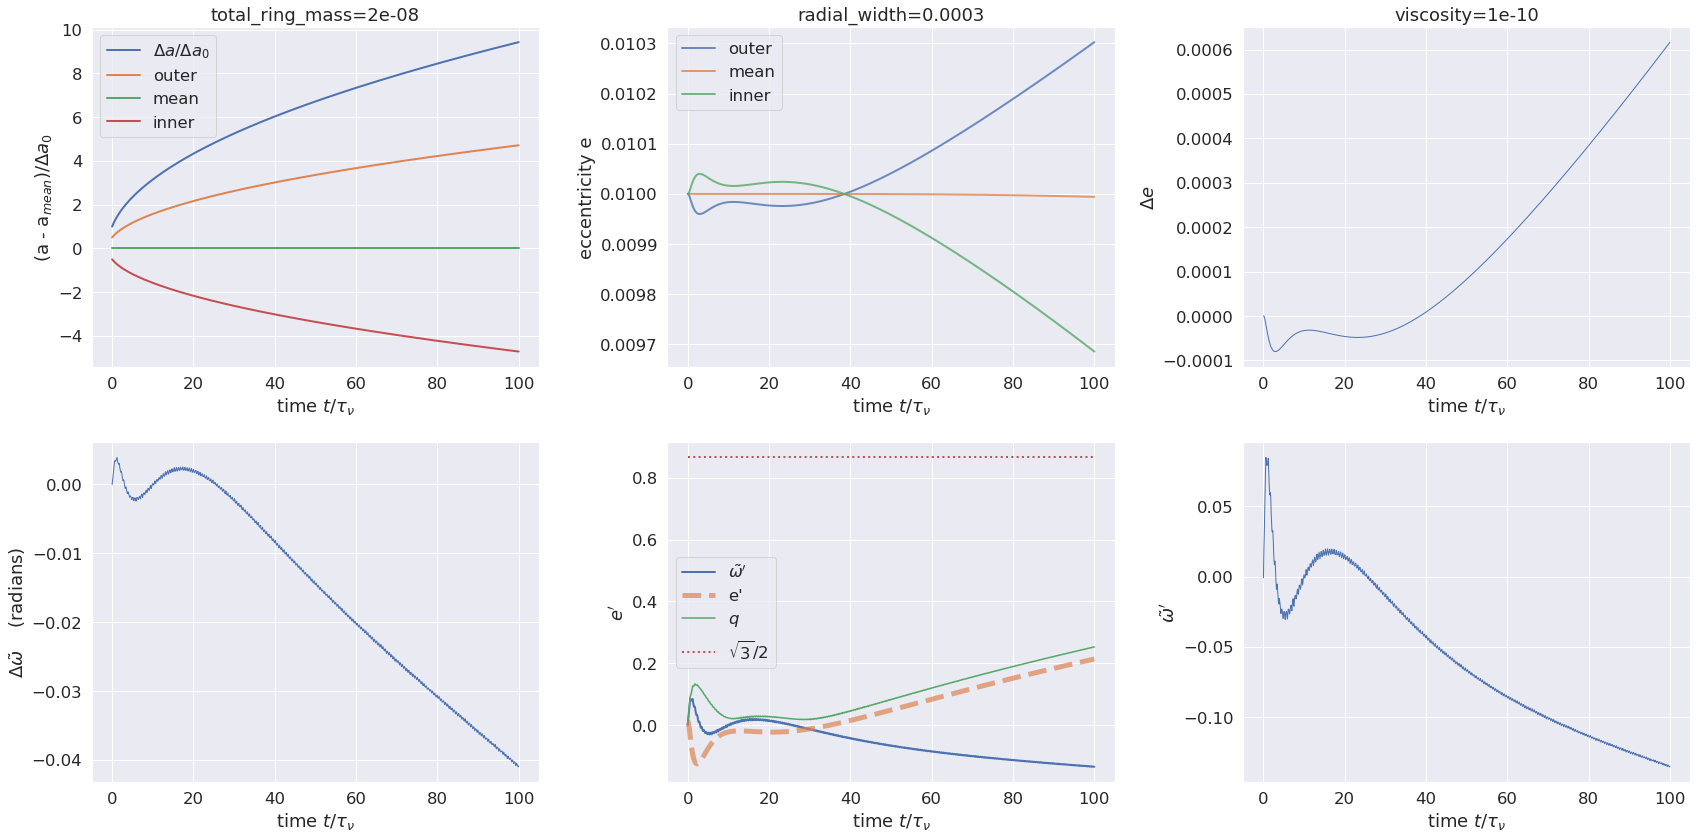

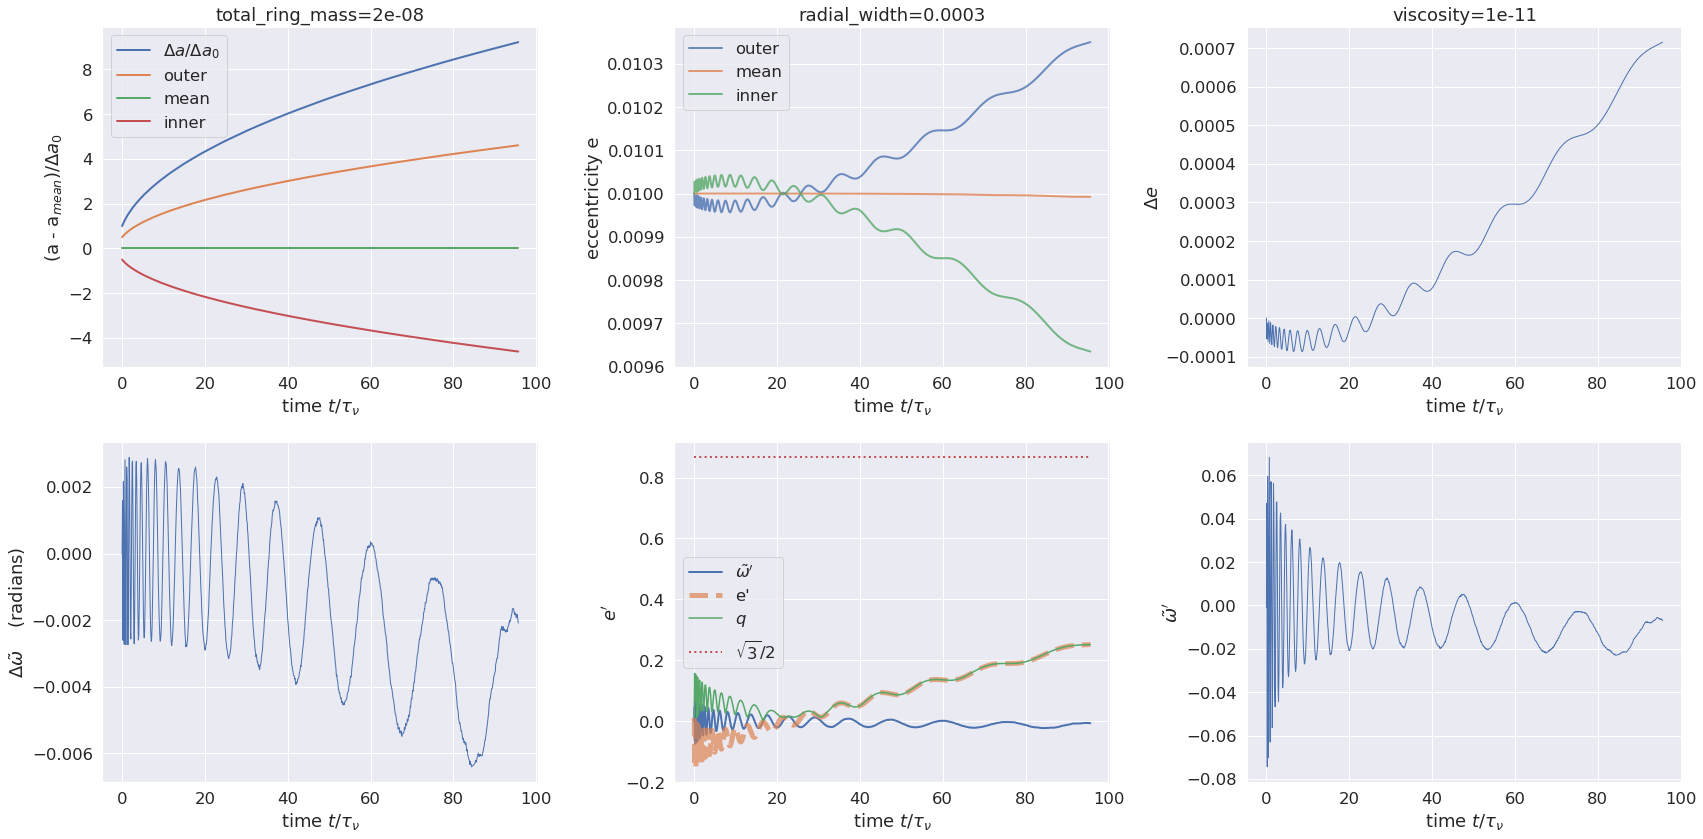

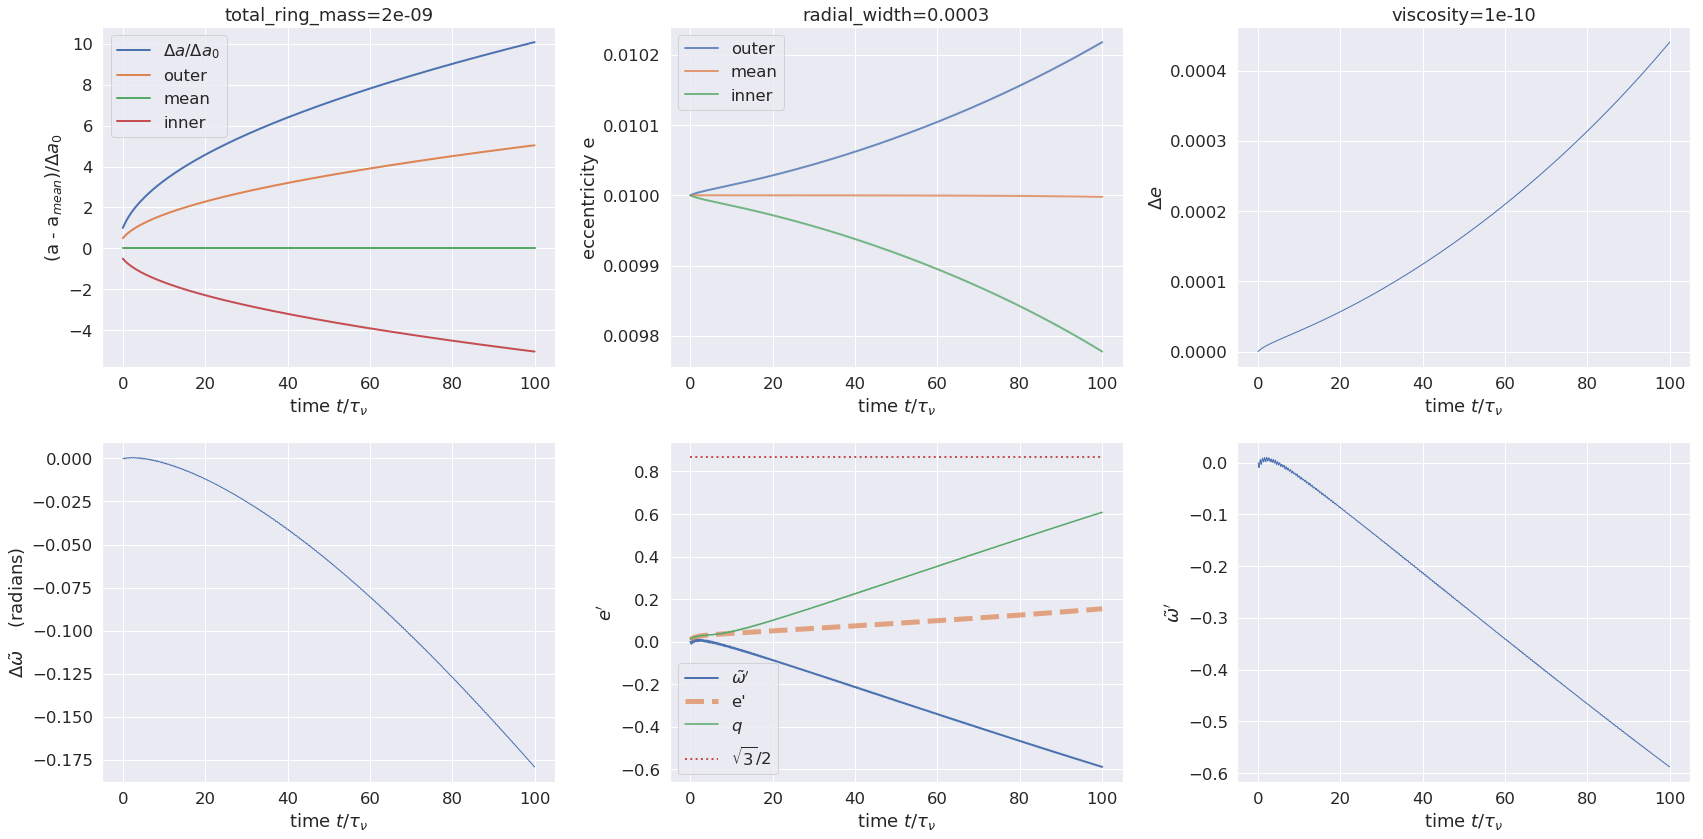

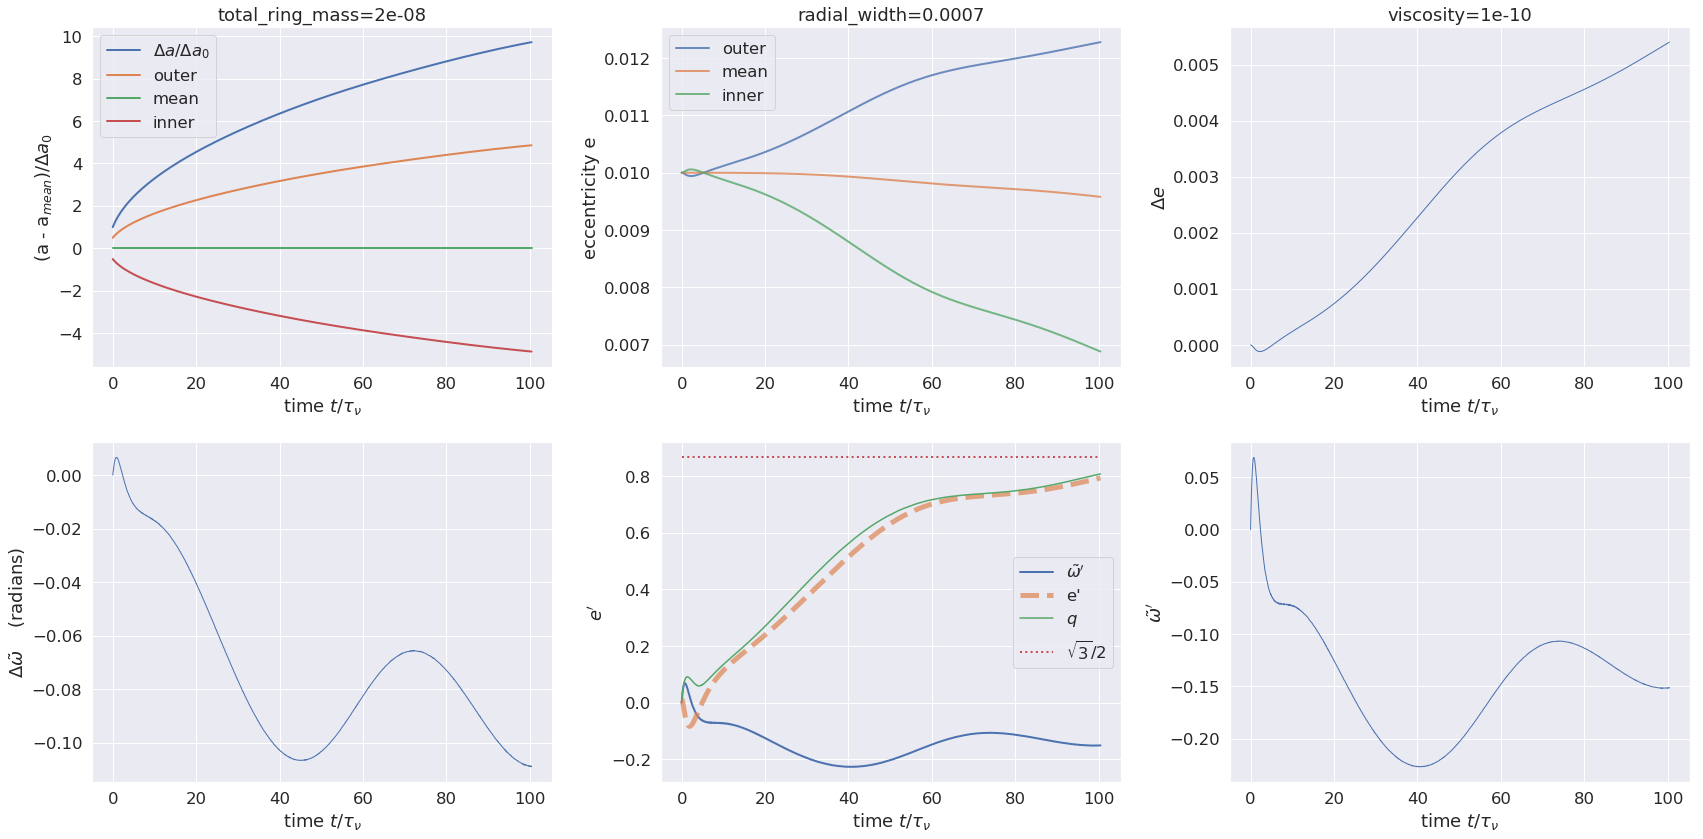

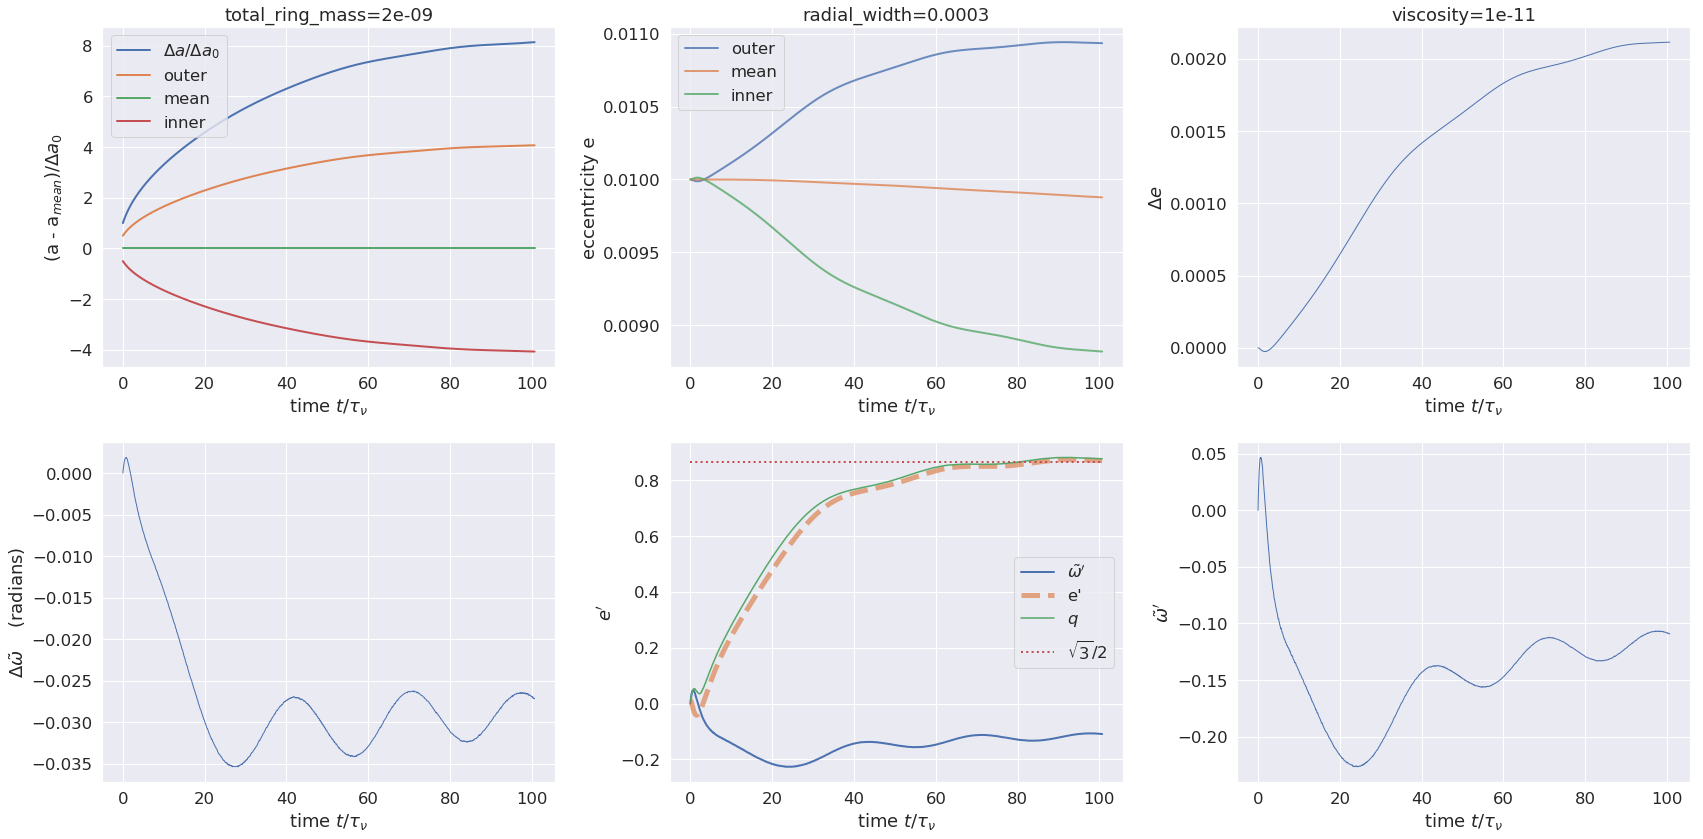

In [4]:
#
debug = False
from helper_fns import *
from libration import *
for path in paths:
    
    #read simulation input and revised output
    execfile('inputs.py')
    r, t, vr, vt, times, lambda0, monitor = restore_output(path)
    modified_params = monitor['modified_params']
    current_timestep = monitor['current_timestep']
    streamline_crossing_timestep = monitor['streamline_crossing_timestep']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
    
    #time in units of viscous timescale
    viscous_timescale = (radial_width**2)/(12*np.abs(shear_viscosity))
    times_viscous = times/viscous_timescale
    print path, int(times_viscous.max())
    
    #report on sims that executed for 100 viscous timescales without crossing streamlines
    if (times_viscous.max() > 90):
        print 'path = ', path
        print 'total_ring_mass = ', total_ring_mass
        print 'radial_width = ', radial_width
        print 'shear_viscosity = ', shear_viscosity
        print 'viscous_timescale = ', viscous_timescale
        print 'current_timestep = ', current_timestep, timesteps_per_output*total_number_of_outputs
        print 'execution time (minutes) = ', (monitor['current_time'] - monitor['start_time'])/60.0
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, a, e, wt)
        da_init = da[0]
        
        #create grid of plots
        sns.set(font_scale=1.5, font='DejaVu Sans')
        fig, axs = plt.subplots(2, 3, figsize=(24, 12))
        
        #plot streamline's mutual a-evolution
        ax = axs[0][0]
        x = times_viscous
        y = da/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$\Delta a/\Delta a_0$')
        y = (a_outer - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='outer')
        y = (a_mean - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='mean')
        y = (a_inner - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=1, label='inner')
        p = ax.set_xlabel(r'time $t/\tau_\nu$')
        p = ax.set_ylabel('(a - a$_{mean})/\Delta a_0$')
        title = 'total_ring_mass=' + str(total_ring_mass)
        p = ax.set_title(title)
        p = ax.legend()
        p = plt.tight_layout()

        #plot streamline's e-evolution
        ax = axs[0][1]
        x = times_viscous
        y = e_outer
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
        y = e_mean
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
        y = e_inner
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
        p = ax.set_ylabel('eccentricity e')
        p = ax.set_xlabel(r'time $t/\tau_\nu$')
        title = 'radial_width=' + str(radial_width)
        p = ax.set_title(title)
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot delta_e versus time
        ax = axs[0][2]
        x = times_viscous
        y = de
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_\nu$')
        p = ax.set_ylabel(r'$\Delta e$')
        title = 'viscosity=' + str(shear_viscosity)
        p = ax.set_title(title)
        p = plt.tight_layout()
        
        #plot dwt versus time
        ax = axs[1][0]
        x = times_viscous
        y = dwt
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_\nu$')
        p = ax.set_ylabel(r'$\Delta\tilde{\omega}$    (radians)')
        p = plt.tight_layout()
        
        #compute e_prime, wt_prime, q to lowest order, and H(q)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        
        #plot e_prime wt_prime and q versus time
        ax = axs[1][1]
        x = times_viscous
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r"$\tilde{\omega}'$")
        y = e_prime
        p = ax.plot(x, y, linestyle='dashed', linewidth=5, alpha=0.7, label="e'")
        y = q
        p = ax.plot(x, y, linestyle='-', linewidth=1.5, label=r'$q$', alpha=1)
        p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dotted', linewidth=2, label=r"$\sqrt{3}/2$")
        p = ax.set_xlabel(r'time $t/\tau_\nu$')
        p = ax.set_ylabel(r"$e'$")
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot wt_prime versus time
        ax = axs[1][2]
        x = times_viscous
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_\nu$')
        p = ax.set_ylabel(r"$\tilde{\omega}'$")
        p = plt.tight_layout()